<a href="https://colab.research.google.com/github/AbdallahAwdalla/Traffic_Signs_Classification/blob/main/Traffic_Signs_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q -U watermark
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.3 MB/s eta 0:00:00
Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

numpy      : 1.23.5
pandas     : 1.5.3
torch      : 2.0.1+cu118
torchvision: 0.15.2+cu118



Needed imports


In [2]:
import torch, torchvision

from pathlib import Path
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
import PIL.Image as Image
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from glob import glob
import shutil
from collections import defaultdict

from torch import nn, optim

import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Download Data Set
GTSRB Contains more than 50,000 annotated images of 40+ traffic signs.


In [3]:
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
!unzip -qq GTSRB_Final_Training_Images.zip

--2023-09-10 13:17:14--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276294756 (263M) [application/zip]
Saving to: ‘GTSRB_Final_Training_Images.zip’

GTSRB_Final_Trainin 100%[===================>] 263.50M  27.9MB/s    in 11s     

2023-09-10 13:17:26 (24.7 MB/s) - ‘GTSRB_Final_Training_Images.zip’ saved [276294756/276294756]



# Explore the data set

In [4]:
# Create a list of paths matching a pathname pattern.
train_folders = sorted(glob('GTSRB/Final_Training/Images/*'))
# Check the list length
len(train_folders)


43

Load and Show the images


<ipython-input-5-efded142bfb1>:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  imgs = torch.as_tensor(imgs)


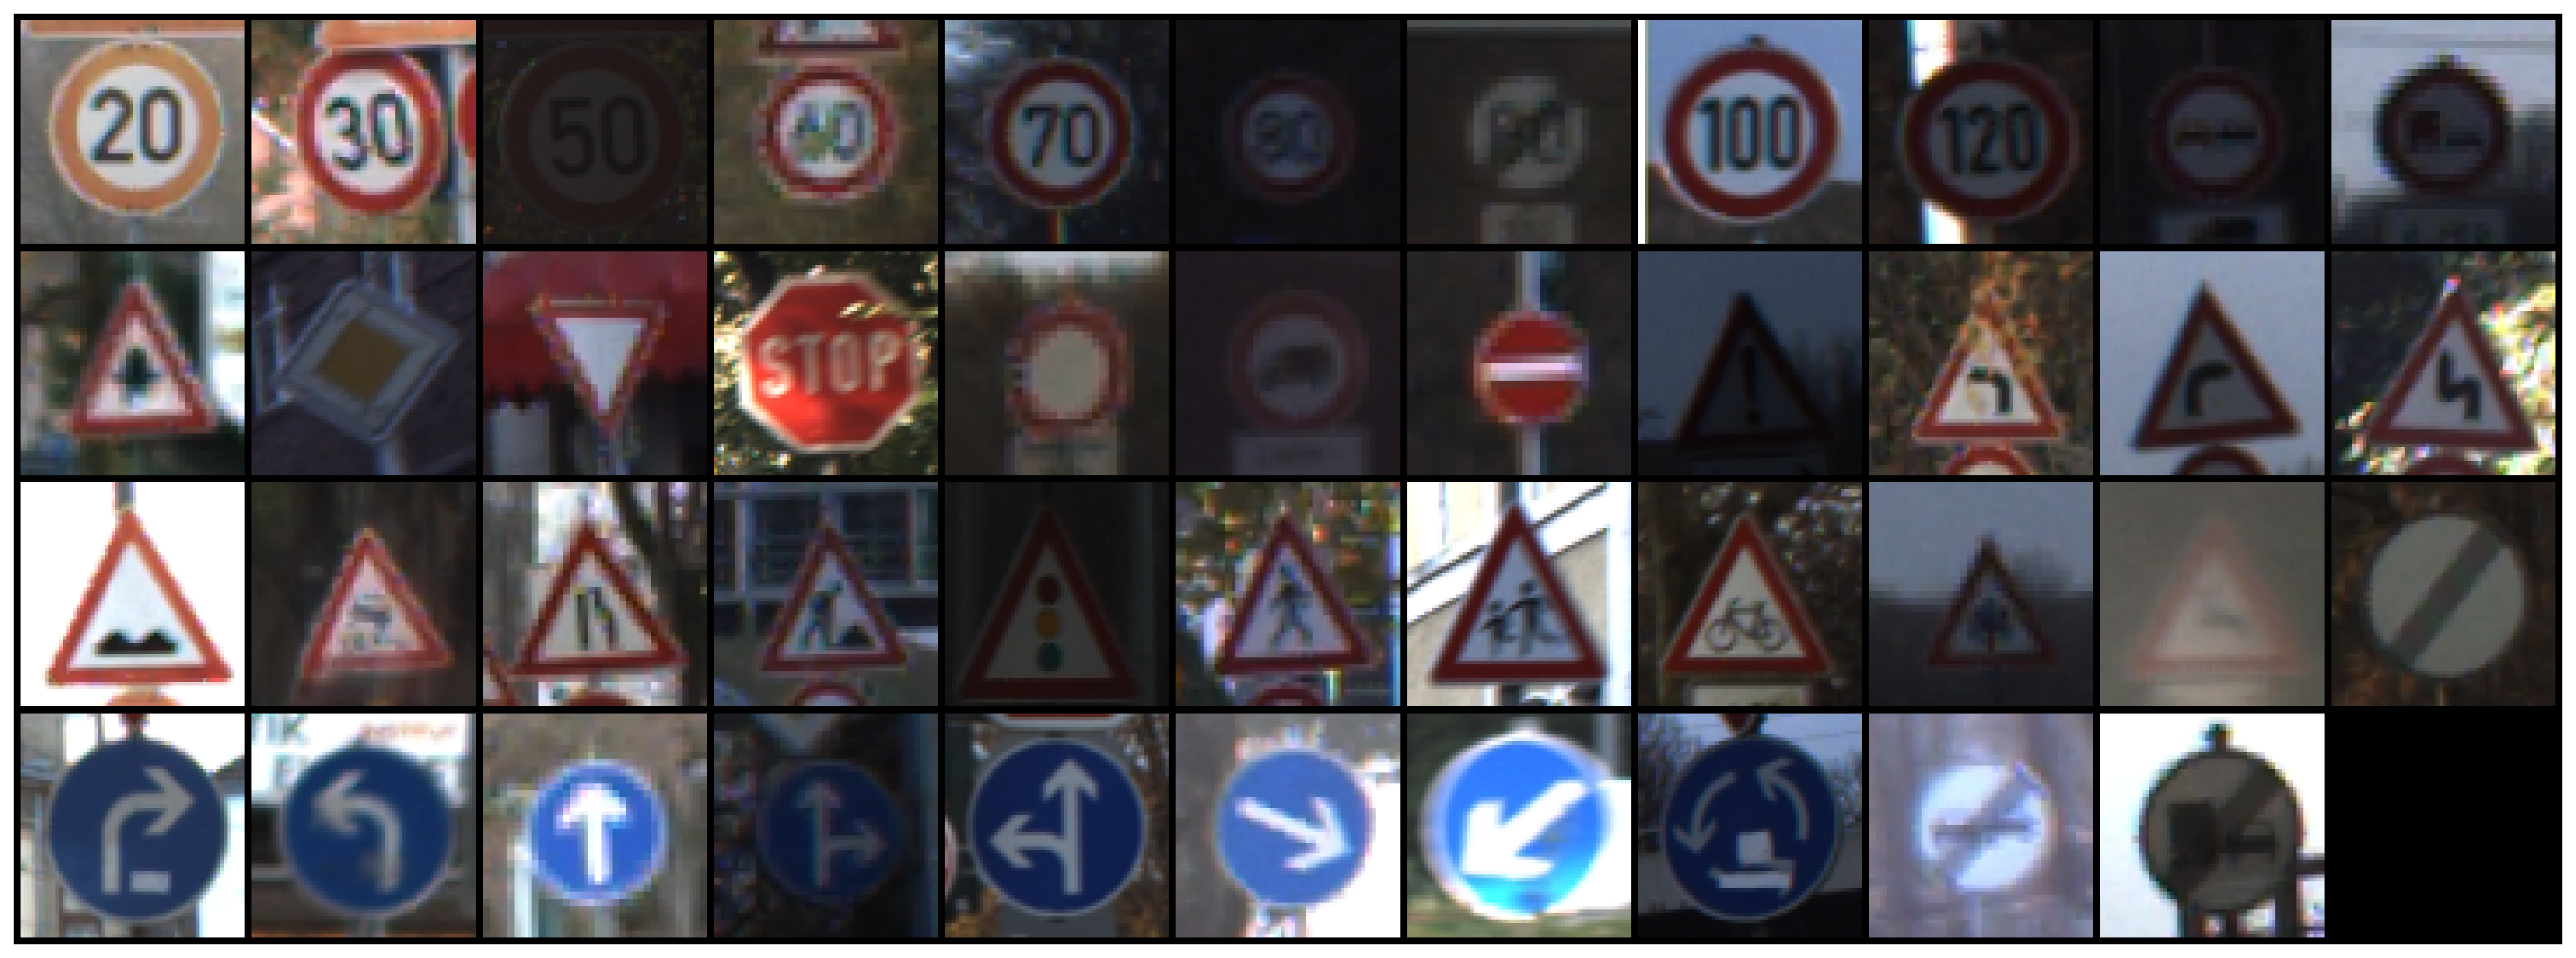

In [5]:
# Load and Resise the image
def load_image(img_path, resize=True):
  img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

  if resize:
    img= cv2.resize(img, (64,64), interpolation = cv2.INTER_AREA)

  return img

# Show the image
def show_image(img_path):
  img = load_image(img_path)
  plt.imshow(img)
  plt.axis('off')

# Show some of the images in a grid
def show_images_in_grid(image_paths):
  imgs = [load_image(img) for img in image_paths]
  imgs = torch.as_tensor(imgs)
  imgs = imgs.permute(0, 3, 1, 2)
  grid_img = torchvision.utils.make_grid(imgs, nrow=11)
  plt.figure(figsize=(24, 12))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off');

sample_images = [np.random.choice(glob(f'{tf}/*ppm')) for tf in train_folders]

show_images_in_grid(sample_images)

# Building A Dataset

In [6]:
# img_path = glob(f'{train_folders[2]}/*ppm')[50]

# show_image(img_path)

class_names = ['priority_road', 'give_way', 'stop', 'no_entry']

class_indices = [12, 13, 14, 17]

# Move dataset to a new directory so it's easier to use Torchvision dataset helpers
!rm -rf data
DATA_DIR = Path('data')
DATASETS = ['train', 'val', 'test']

# Create sepreate folders for traing, validation and test dataset
for ds in DATASETS:
  for cls in class_names:
    (DATA_DIR / ds / cls).mkdir(parents= True, exist_ok= True)


# Splid data into (80% Training, 10% Validation and 10% For Testing )
for i, cls_index in enumerate(class_indices):
  image_paths = np.array(glob(f'{train_folders[cls_index]}/*.ppm'))
  class_name = class_names[i]
  print(f'{class_name}: {len(image_paths)}')
  np.random.shuffle(image_paths)

  ds_split = np.split(
    image_paths,
    indices_or_sections=[int(.8*len(image_paths)), int(.9*len(image_paths))]
  )

  dataset_data = zip(DATASETS, ds_split)

  for ds, images in dataset_data:
    for img_path in images:
      shutil.copy(img_path, f'{DATA_DIR}/{ds}/{class_name}/')


priority_road: 2100
give_way: 2160
stop: 780
no_entry: 1110


DATA_AUGMENTATION

In [7]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

transforms = {'train': T.Compose([
  T.RandomResizedCrop(size=256),
  T.RandomRotation(degrees=15),
  T.RandomHorizontalFlip(),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'val': T.Compose([
  T.Resize(size=256),
  T.CenterCrop(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'test': T.Compose([
  T.Resize(size=256),
  T.CenterCrop(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]),
}

Create a PyTorch for each image dataset folder and data loaders

In [8]:
image_datasets = {
  d: ImageFolder(f'{DATA_DIR}/{d}', transforms[d]) for d in DATASETS
}

data_loaders = {
  d: DataLoader(image_datasets[d],
                batch_size=4,
                shuffle=True,
                num_workers=4)
  for d in DATASETS
}

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [9]:
dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets['train'].classes

dataset_sizes

{'train': 4920, 'val': 615, 'test': 615}

# Using a pre-trained model

In [10]:
#Using Transfer Learning to copy the architecture of the very popular ResNet model.
# On top of that, we'll use the learned weights of the model from training on the ImageNet dataset
def create_model(n_classes):
  model = models.resnet34(pretrained=True)

  n_features = model.fc.in_features
  # Replace the fully connected layer
  model.fc = nn.Linear(n_features, n_classes)

  return model.to(device)

In [11]:
# Create an instance of the new model
base_model = create_model(len(class_names))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 114MB/s]


## Training

In [12]:
# Define helper functions to abstract the training process
def train_epoch(
    model,
    data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0

  for inputs, labels in data_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)

    _,preds = torch.max(outputs, dim =1)
    loss = loss_fn(outputs, labels)

    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  scheduler.step()

  return correct_predictions.double() / n_examples, np.mean(losses)


def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)

      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, labels)

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

##  evaluation of the model

In [13]:
def train_model(model, data_loaders, dataset_sizes, device, n_epochs=3):
  optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
  scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
  loss_fn = nn.CrossEntropyLoss().to(device)

  history = defaultdict(list)
  best_accuracy = 0

  for epoch in range(n_epochs):

    print(f'Epoch {epoch + 1}/{n_epochs}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
      model,
      data_loaders['train'],
      loss_fn,
      optimizer,
      device,
      scheduler,
      dataset_sizes['train']
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
      model,
      data_loaders['val'],
      loss_fn,
      device,
      dataset_sizes['val']
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
      torch.save(model.state_dict(), 'best_model_state.bin')
      best_accuracy = val_acc

  print(f'Best val accuracy: {best_accuracy}')

  model.load_state_dict(torch.load('best_model_state.bin'))

  return model, history




def plot_training_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

  ax1.plot(history['train_loss'], label='train loss')
  ax1.plot(history['val_loss'], label='validation loss')

  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax1.set_ylim([-0.05, 1.05])
  ax1.legend()
  ax1.set_ylabel('Loss')
  ax1.set_xlabel('Epoch')

  ax2.plot(history['train_acc'], label='train accuracy')
  ax2.plot(history['val_acc'], label='validation accuracy')

  ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax2.set_ylim([-0.05, 1.05])
  ax2.legend()

  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epoch')

  fig.suptitle('Training history')

### Train the model

In [ ]:

base_model, history = train_model(base_model, data_loaders, dataset_sizes, device)

Epoch 1/3
----------
